In [6]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq, MAT, Statistics, LinearAlgebra

In [7]:
WT = [-100.54644808743168 907.6923076923085;
-69.03460837887067 1492.307692307695;
-49.72677595628414 753.8461538461561;
-39.890710382513646 1430.7692307692341;
-15.118397085610184 2046.1538461538476;
0.18214936247724722 2015.384615384617;
0.9107468123861509 10753.846153846156;
2.185792349726796 10815.384615384617;
5.1001821493624675 12384.615384615387;
14.936247723132965 12384.615384615387;
35.154826958105645 10538.461538461539]

GS_AMP_mean = [-100.54644808743168 1707.6923076923085;
-69.03460837887067 969.2307692307695;
-49.72677595628414 -723.076923076922;
-39.70856102003643 969.2307692307695;
-14.754098360655732 230.76923076923413;
0.18214936247724722 1000.00002111213731;
0.9107468123861509 11984.615384615387;
2.185792349726796 12107.692307692309;
5.1001821493624675 13215.384615384617;
15.118397085610212 7953.846153846152;
34.9726775956284 2292.307692307695]



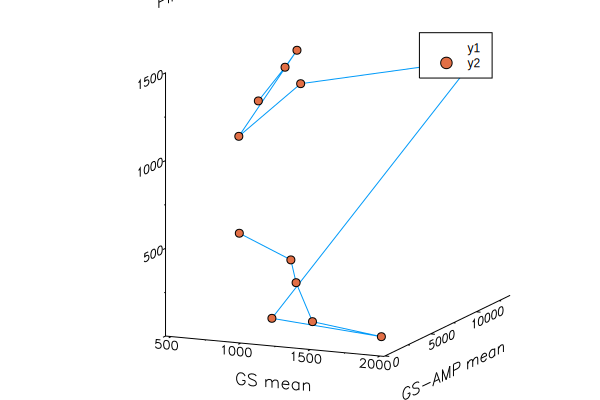

In [8]:
#a = GS_mean[:,2]
b = GS_AMP_mean[:,2]
c = PII[:,2]
d = PII_UMP[:,2]
plt=plot(d,b,c, xlab = "GS mean", ylab = "GS-AMP mean", zlab  = "PII", grid = "off")
scatter!(d,b,c)

In [13]:
# Observed data
ode_data = transpose(hcat( b, c, d))
u0 = [ b[1], c[1], d[1]]
tspan = (0.,1.)
t = GS_mean[:,1].+abs(GS_mean[1])
t = t./t[end]
# species1 = "GS"
species2 = "GS-AMP"
species3 = "PII"
species4 = "PII-UMP";

In [14]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()), n_epochs)
    count_epochs = 0
    return saver(losses, l2s, times, count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

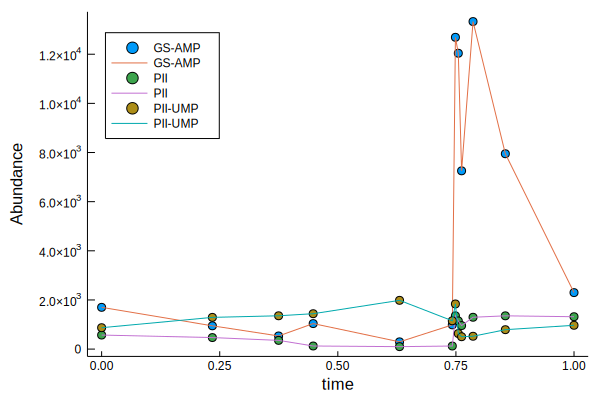

In [21]:

#scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species1, legend =:topleft)
#plot!(t, ode_data[1,:], label = species1)

scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = "GS-AMP ", legend =:topleft)
plot!(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = "GS-AMP ")

scatter!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = "PII ")
plot!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = "PII ")

scatter!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = "PII-UMP ")
plot!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = "PII-UMP ")

In [38]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(3,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,100,tanh),
       Dense(100,3))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
# Rosenbrock23, TRBDF2, ABDF2, Rodas5, Rodas4P, Kvaerno5, KenCarp4, CVODE_BDF (not defined)
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Rosenbrock23(autodiff=false), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Rosenbrock23(autodiff=false), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 10000
verify = 1000 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.01)
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()),Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0,Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end

#37 (generic function with 1 method)

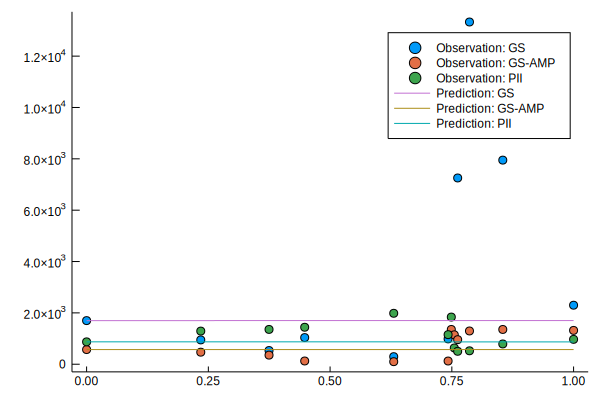

In [39]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
scatter!(t, ode_data[3,:], label = string("Observation: ", species3))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species3))

In [40]:
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

246.140776 seconds (221.06 M allocations: 122.523 GiB, 13.41% gc time)


In [41]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species1),, grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
scatter!(t, ode_data[3,:], label = string("Observation: ", species3))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species3))

LoadError: syntax: unexpected ","

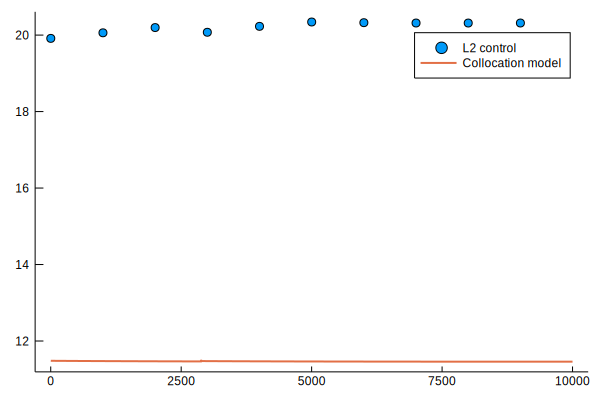

In [42]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s

In [32]:
opt1 = ADAM(0.1)
sa = saver(n_epochs)
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

 77.035666 seconds (86.33 M allocations: 21.539 GiB, 6.89% gc time)


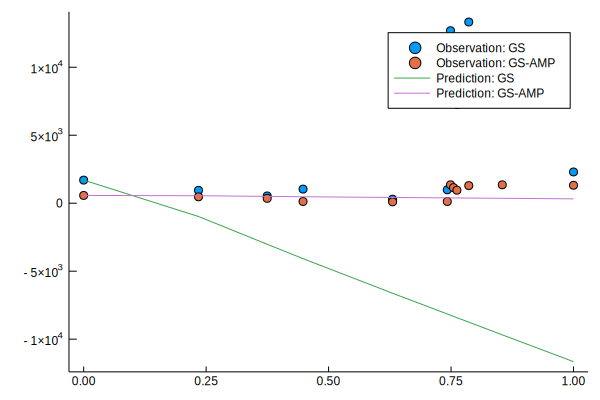

In [33]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species2))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species2))

In [ ]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s